In [ ]:
"""
FloodNet Dataset – Exploration & Preprocessing Overview
------------------------------------------------------

This script focuses on preparing and understanding the FloodNet dataset
before model training. It includes steps for dataset inspection,
visualization, preprocessing, and class weight computation to handle
imbalances in segmentation masks.
"""
# ============================================================
# Objectives
# ============================================================
# 1. Explore dataset structure and statistics
# 2. Analyze class distribution
# 3. Visualize sample images and masks
# 4. Build a preprocessing pipeline for model-ready inputs
# 5. Calculate class weights for handling imbalance

In [ ]:
# ============================================================
# 1. Setup and Imports
# ------------------------------------------------------------
# This section initializes the essential libraries and modules 
# required for data exploration, visualization, and preprocessing.
# It includes utilities for file handling, image processing, 
# statistical analysis, progress tracking, and warning management.
# ============================================================

# Standard library imports
import os       # For directory and path operations
import sys      # For system-level configurations and utilities
from pathlib import Path  # For object-oriented filesystem paths
from collections import Counter  # For class frequency counting

# Third-party libraries
import cv2                      # OpenCV for image loading and manipulation
import numpy as np              # Numerical computations and array operations
import pandas as pd             # Data loading, tabular processing, statistics
import matplotlib.pyplot as plt # Plotting and visualizations
import seaborn as sns           # Advanced statistical plots
from tqdm import tqdm           # Progress bars for loops

# Suppress unnecessary warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')


In [3]:
# Add src to path
sys.path.append('../src')

In [4]:
# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print(" Libraries imported successfully!")

 Libraries imported successfully!


In [ ]:
# ============================================================
# 2. Configuration
# ------------------------------------------------------------
# Load configuration from file if available; otherwise define 
# an inline fallback Config class with dataset paths & parameters.
# ============================================================

try:
    from src.utils.config import Config
    print(" Config loaded from file")
except ImportError:
    print(" Config not found, using inline configuration")
    
    class Config:
        # Update this path to match your setup
        BASE_DIR = Path(r"D:\Projects\Image Segmentation for Disaster Resilience\Disaster-segmentation")
        
        # Dataset paths
        RAW_DATA = BASE_DIR / "data" / "raw" / "FloodNet"
        TRAIN_IMAGES = RAW_DATA / "train" / "train-org-img"
        TRAIN_MASKS = RAW_DATA / "train" / "train-label-img"
        VAL_IMAGES = RAW_DATA / "val" / "val-org-img"
        VAL_MASKS = RAW_DATA / "val" / "val-label-img"
        TEST_IMAGES = RAW_DATA / "test" / "test-org-img"
        TEST_MASKS = RAW_DATA / "test" / "test-label-img"
        
        # Result dictories
        RESULTS_DIR = BASE_DIR / "results"
        VIZ_DIR = RESULTS_DIR / "visualizations" / "data_exploration"
        
        # Image Parameters
        IMG_HEIGHT = 256
        IMG_WIDTH = 256
        NUM_CLASSES = 10
        
        # Classes
        CLASSES = {
            0: "Background", 1: "Building-flooded", 2: "Building-non-flooded",
            3: "Road-flooded", 4: "Road-non-flooded", 5: "Water",
            6: "Tree", 7: "Vehicle", 8: "Pool", 9: "Grass"
        }
        
        # Class-to-color mapping for mask visualization
        CLASS_COLORS = {
            0: (0, 0, 0), 1: (255, 0, 0), 2: (0, 0, 255),
            3: (255, 165, 0), 4: (128, 128, 128), 5: (0, 255, 255),
            6: (0, 255, 0), 7: (255, 0, 255), 8: (255, 255, 255), 9: (0, 128, 0)
        }

# Create visualization directory
Config.VIZ_DIR.mkdir(parents=True, exist_ok=True)

print(f"Base Directory: {Config.BASE_DIR}")

 Config not found, using inline configuration
Base Directory: D:\Projects\Image Segmentation for Disaster Resilience\Disaster-segmentation


In [ ]:
# ============================================================
# 3. Dataset Exploration
# ------------------------------------------------------------
# Basic dataset inspection: count images and masks in each split.
# Provides quick validation of directory structure and file presence.
# ============================================================

def count_files(directory):
    """Count files in a directory"""
    if directory.exists():
        files = list(directory.glob("*"))
        return len(files), files
    return 0, []

# Display dataset statistics header
print("=" * 60)
print("DATASET STATISTICS")
print("=" * 60)

# Map dataset components to their paths
datasets = {
    "Train Images": Config.TRAIN_IMAGES,
    "Train Masks": Config.TRAIN_MASKS,
    "Val Images": Config.VAL_IMAGES,
    "Val Masks": Config.VAL_MASKS,
    "Test Images": Config.TEST_IMAGES,
    "Test Masks": Config.TEST_MASKS,
}

# Count files for each directory
stats = {}
for name, path in datasets.items():
    count, files = count_files(path)
    stats[name] = {"count": count, "path": path, "files": files}
    status = "✅" if count > 0 else "❌"
    print(f"{status} {name}: {count} files")


DATASET STATISTICS
✅ Train Images: 1445 files
✅ Train Masks: 1445 files
✅ Val Images: 450 files
✅ Val Masks: 450 files
✅ Test Images: 448 files
✅ Test Masks: 448 files


In [ ]:
# ============================================================
# 4. Analyze Image Properties
# ------------------------------------------------------------
# Check image dimensions and file sizes to ensure consistency 
# across the dataset and detect anomalies.
# ============================================================

def analyze_image_properties(image_dir, sample_size=50):
    """Analyze image shapes and file sizes from a sample."""
    files = list(image_dir.glob("*"))[:sample_size]

    dimensions = []
    file_sizes = []

    for f in files:
        img = cv2.imread(str(f))
        if img is not None:
            dimensions.append(img.shape)               # (H, W, C)
            file_sizes.append(f.stat().st_size / 1024) # Size in KB

    return dimensions, file_sizes

# Header for image property analysis
print("\n" + "=" * 60)
print("IMAGE PROPERTIES ANALYSIS")
print("=" * 60)

# Run analysis on training images
if stats["Train Images"]["count"] > 0:
    dims, sizes = analyze_image_properties(Config.TRAIN_IMAGES)

    print(f"\nSampled {len(dims)} images:")
    print(f"  Dimensions: {dims[0] if dims else 'N/A'}")
    print(f"  Unique shapes: {len(set(dims))}")
    print(f"  Average file size: {np.mean(sizes):.1f} KB")
    print(f"  Min file size: {np.min(sizes):.1f} KB")
    print(f"  Max file size: {np.max(sizes):.1f} KB")



IMAGE PROPERTIES ANALYSIS

Sampled 50 images:
  Dimensions: (3000, 4000, 3)
  Unique shapes: 2
  Average file size: 5617.9 KB
  Min file size: 4841.8 KB
  Max file size: 7726.3 KB


Sample IMAGE filenames:
   10165.jpg
   10166.jpg
   10168.jpg
   10170.jpg
   10171.jpg

Sample MASK filenames:
   10165_lab.png
   10166_lab.png
   10168_lab.png
   10170_lab.png
   10171_lab.png

Naming Pattern Analysis:
   Image example: 10165.jpg
   Mask example:  10165_lab.png
   Image stem: '10165', ext: '.jpg'
   Mask stem:  '10165_lab', ext: '.png'
    Pattern: Image name + '_lab' suffix

Testing mask matching:
   10165.jpg → 10165_lab.png ✅
   10166.jpg → 10166_lab.png ✅
   10168.jpg → 10168_lab.png ✅
   10170.jpg → 10170_lab.png ✅
   10171.jpg → 10171_lab.png ✅

FIXED SAMPLE VISUALIZATION
Saved to: D:\Projects\Image Segmentation for Disaster Resilience\Disaster-segmentation\results\visualizations\data_exploration\sample_train_images_fixed.png


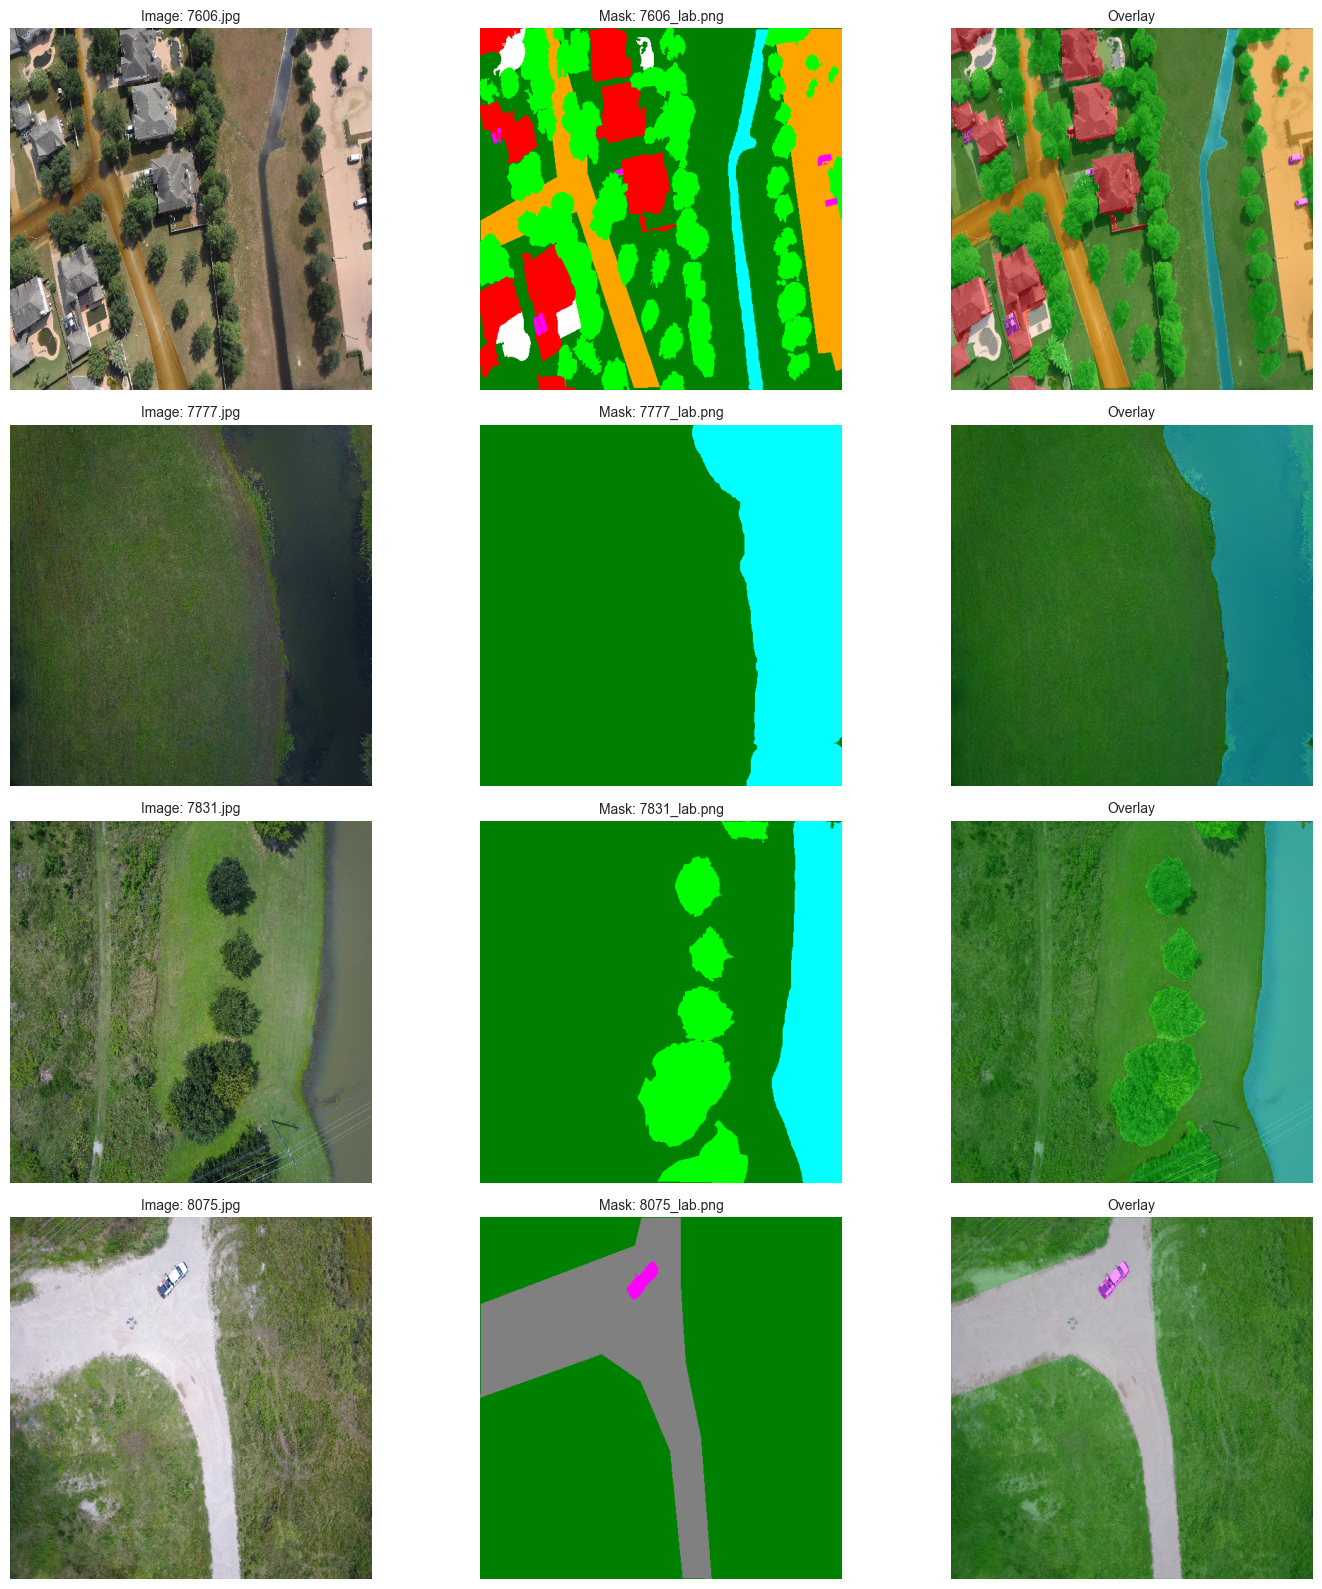


VERIFYING ALL IMAGE-MASK PAIRS

All images have matching masks!

Summary:
   Total images: 1445
   Total masks:  1445
   Missing:      0


In [ ]:
# ============================================================
# Dataset Matching & Visualization (Train split)
# ============================================================
# Short, clear mix of docstrings, section blocks and inline notes.
# Purpose: detect image↔mask naming pattern, match masks robustly,
# visualize samples (image, colored mask, overlay) and report missing.
# ============================================================

import os
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# Paths (update if needed)
# -------------------------
train_img_dir = Path(
    r"D:\Projects\Image Segmentation for Disaster Resilience\Disaster-segmentation\data\raw\FloodNet\train\train-org-img"
)
train_mask_dir = Path(
    r"D:\Projects\Image Segmentation for Disaster Resilience\Disaster-segmentation\data\raw\FloodNet\train\train-label-img"
)

# -------------------------
# Quick sample listing
# -------------------------
img_files = sorted(list(train_img_dir.glob("*")))[:5]
mask_files = sorted(list(train_mask_dir.glob("*")))[:5]

print("Sample IMAGE filenames:")
for f in img_files:
    print(f"   {f.name}")

print("\nSample MASK filenames:")
for f in mask_files:
    print(f"   {f.name}")


# -------------------------
# Naming pattern detection
# -------------------------
def detect_naming_pattern(img_dir, mask_dir):
    """
    Inspect first filename pair and print common naming patterns.
    Returns a pattern key for informational purposes.
    """
    img_files = list(img_dir.glob("*"))
    mask_files = list(mask_dir.glob("*"))

    if not img_files or not mask_files:
        return None

    img_name = img_files[0].stem
    img_ext = img_files[0].suffix
    mask_name = mask_files[0].stem
    mask_ext = mask_files[0].suffix

    print("\nNaming Pattern Analysis:")
    print(f"   Image example: {img_files[0].name}")
    print(f"   Mask example:  {mask_files[0].name}")
    print(f"   Image stem: '{img_name}', ext: '{img_ext}'")
    print(f"   Mask stem:  '{mask_name}', ext: '{mask_ext}'")

    # Heuristic checks for common patterns
    if mask_name == img_name:
        pattern = "same_name"
        print("    Pattern: Same name, different extension")
    elif mask_name == f"{img_name}_lab":
        pattern = "add_lab_suffix"
        print("    Pattern: Image name + '_lab' suffix")
    elif mask_name == f"{img_name}_mask":
        pattern = "add_mask_suffix"
        print("    Pattern: Image name + '_mask' suffix")
    elif img_name in mask_name:
        pattern = "contains_name"
        suffix = mask_name.replace(img_name, "")
        print(f"    Pattern: Image name + '{suffix}' suffix")
    else:
        pattern = "unknown"
        print("    Pattern: Unknown - manual matching needed")

    return pattern


pattern = detect_naming_pattern(train_img_dir, train_mask_dir)


# -------------------------
# Robust mask lookup
# -------------------------
def get_mask_path(image_path, mask_dir):
    """
    Given an image path, return the corresponding mask path.
    Tries common suffixes/extensions, then falls back to substring match.
    """
    img_stem = image_path.stem

    # Common candidate filenames to try
    candidates = [
        f"{img_stem}.png",
        f"{img_stem}_lab.png",
        f"{img_stem}_mask.png",
        f"{img_stem}_label.png",
        f"{img_stem}.jpg",
        f"{img_stem}_lab.jpg",
        f"{img_stem}.tif",
        f"{img_stem}.bmp",
    ]

    for name in candidates:
        p = mask_dir / name
        if p.exists():
            return p

    # Fallback: any file containing the image stem
    match = next(mask_dir.glob(f"*{img_stem}*"), None)
    return match


# -------------------------
# Test matching on a few files
# -------------------------
print("\nTesting mask matching:")
for img_path in img_files:
    mask_path = get_mask_path(img_path, train_mask_dir)
    status = "✅" if mask_path else "❌"
    mask_name = mask_path.name if mask_path else "NOT FOUND"
    print(f"   {img_path.name} → {mask_name} {status}")


# -------------------------
# Visualization utilities
# -------------------------
CLASS_COLORS = {
    0: (0, 0, 0), 1: (255, 0, 0), 2: (0, 0, 255),
    3: (255, 165, 0), 4: (128, 128, 128), 5: (0, 255, 255),
    6: (0, 255, 0), 7: (255, 0, 255), 8: (255, 255, 255), 9: (0, 128, 0)
}


def load_image(path):
    """Load BGR image and convert to RGB."""
    img = cv2.imread(str(path))
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if img is not None else None


def load_mask(path):
    """Load mask as single-channel (grayscale / class ids)."""
    return cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)


def colorize_mask(mask):
    """Map integer mask values to RGB colors using CLASS_COLORS."""
    h, w = mask.shape
    colored = np.zeros((h, w, 3), dtype=np.uint8)
    for class_id, color in CLASS_COLORS.items():
        colored[mask == class_id] = color
    return colored


def visualize_samples_fixed(image_dir, mask_dir, num_samples=4, save_path=None):
    """
    Visualize random samples with matched masks.
    Columns: [Image, Colored Mask, Overlay].
    """
    image_files = sorted(list(image_dir.glob("*")))
    if not image_files:
        print("No images to visualize.")
        return

    # choose indices without replacement
    indices = np.random.choice(len(image_files), min(num_samples, len(image_files)), replace=False)

    fig, axes = plt.subplots(min(num_samples, len(indices)), 3, figsize=(15, 4 * len(indices)))

    for i, idx in enumerate(indices):
        img_path = image_files[idx]
        mask_path = get_mask_path(img_path, mask_dir)

        img = load_image(img_path)
        if img is None:
            # skip invalid images
            axes[i, 0].text(0.5, 0.5, "Image load failed", ha="center", va="center")
            axes[i, 0].axis("off")
            axes[i, 1].axis("off")
            axes[i, 2].axis("off")
            continue

        img_resized = cv2.resize(img, (512, 512))

        # Column 1: original image
        axes[i, 0].imshow(img_resized)
        axes[i, 0].set_title(f"Image: {img_path.name}", fontsize=10)
        axes[i, 0].axis("off")

        if mask_path and mask_path.exists():
            mask = load_mask(mask_path)
            mask_resized = cv2.resize(mask, (512, 512), interpolation=cv2.INTER_NEAREST)
            colored_mask = colorize_mask(mask_resized)

            # Column 2: colored mask
            axes[i, 1].imshow(colored_mask)
            axes[i, 1].set_title(f"Mask: {mask_path.name}", fontsize=10)
            axes[i, 1].axis("off")

            # Column 3: overlay
            overlay = cv2.addWeighted(img_resized, 0.6, colored_mask, 0.4, 0)
            axes[i, 2].imshow(overlay)
            axes[i, 2].set_title("Overlay", fontsize=10)
            axes[i, 2].axis("off")
        else:
            # If mask missing, show informative message
            axes[i, 1].text(0.5, 0.5, "Mask not found", ha="center", va="center", fontsize=10)
            axes[i, 1].axis("off")
            axes[i, 2].axis("off")

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
        print(f"Saved to: {save_path}")

    plt.show()


# -------------------------
# Run visualization & verify pairs
# -------------------------
print("\n" + "=" * 60)
print("FIXED SAMPLE VISUALIZATION")
print("=" * 60)

results_dir = Path(
    r"D:\Projects\Image Segmentation for Disaster Resilience\Disaster-segmentation\results\visualizations\data_exploration"
)
results_dir.mkdir(parents=True, exist_ok=True)

visualize_samples_fixed(
    train_img_dir,
    train_mask_dir,
    num_samples=4,
    save_path=results_dir / "sample_train_images_fixed.png"
)

# -------------------------
# Verify presence of masks for all images
# -------------------------
print("\n" + "=" * 60)
print("VERIFYING ALL IMAGE-MASK PAIRS")
print("=" * 60)

missing_masks = []
all_images = list(train_img_dir.glob("*"))
for img_path in all_images:
    mask_path = get_mask_path(img_path, train_mask_dir)
    if not mask_path:
        missing_masks.append(img_path.name)

if missing_masks:
    print(f"\nFound {len(missing_masks)} images without masks:")
    for m in missing_masks[:10]:
        print(f"   - {m}")
    if len(missing_masks) > 10:
        print(f"   ... and {len(missing_masks) - 10} more")
else:
    print("\nAll images have matching masks!")

print("\nSummary:")
print(f"   Total images: {len(all_images)}")
print(f"   Total masks:  {len(list(train_mask_dir.glob('*')))}")
print(f"   Missing:      {len(missing_masks)}")


In [ ]:
# ============================================================
# 6. Class Distribution Analysis
# ------------------------------------------------------------
# Compute pixel-wise frequency of each class across mask files,
# summarize into a DataFrame, and save results as CSV.
# ============================================================

def analyze_class_distribution(mask_dir, num_samples=None):
    """
    Compute pixel counts per class from masks.
    
    Args:
        mask_dir (Path): directory containing mask files.
        num_samples (int|None): limit number of masks to process.
    
    Returns:
        (Counter, int): (class_pixels_counter, total_pixel_count)
    """
    mask_files = sorted(list(mask_dir.glob("*")))
    if num_samples:
        mask_files = mask_files[:num_samples]

    class_pixels = Counter()  # accumulate pixel counts per class
    total_pixels = 0

    print(f"Analyzing {len(mask_files)} masks...")

    for mask_path in tqdm(mask_files, desc="Processing masks"):
        mask = load_mask(mask_path)            # load as single-channel class ids
        if mask is not None:
            unique, counts = np.unique(mask, return_counts=True)
            for cls, count in zip(unique, counts):
                class_pixels[int(cls)] += int(count)
                total_pixels += int(count)

    return class_pixels, total_pixels


# -------------------------
# Run analysis (training masks)
# -------------------------
print("\n" + "=" * 60)
print("CLASS DISTRIBUTION ANALYSIS")
print("=" * 60)

class_pixels, total_pixels = analyze_class_distribution(Config.TRAIN_MASKS)

# -------------------------
# Build results DataFrame
# -------------------------
distribution_data = []
for cls_id in range(Config.NUM_CLASSES):
    count = class_pixels.get(cls_id, 0)
    percentage = (count / total_pixels) * 100 if total_pixels > 0 else 0.0
    distribution_data.append({
        "Class ID": int(cls_id),
        "Class Name": Config.CLASSES.get(cls_id, f"Class_{cls_id}"),
        "Pixel Count": int(count),
        "Percentage": float(percentage)
    })

df_distribution = pd.DataFrame(distribution_data)

# Pretty-print to console
print("\n")
print(df_distribution.to_string(index=False))

# -------------------------
# Save results
# -------------------------
metrics_dir = Config.RESULTS_DIR / "metrics"
metrics_dir.mkdir(parents=True, exist_ok=True)  # ensure directory exists
out_path = metrics_dir / "class_distribution.csv"
df_distribution.to_csv(out_path, index=False)
print(f"\nSaved to: {out_path}")



CLASS DISTRIBUTION ANALYSIS
Analyzing 1445 masks...


Processing masks:  66%|██████▌   | 950/1445 [02:56<01:18,  6.27it/s]

Saved to: D:\Projects\Image Segmentation for Disaster Resilience\Disaster-segmentation\results\visualizations\data_exploration\class_distribution.png


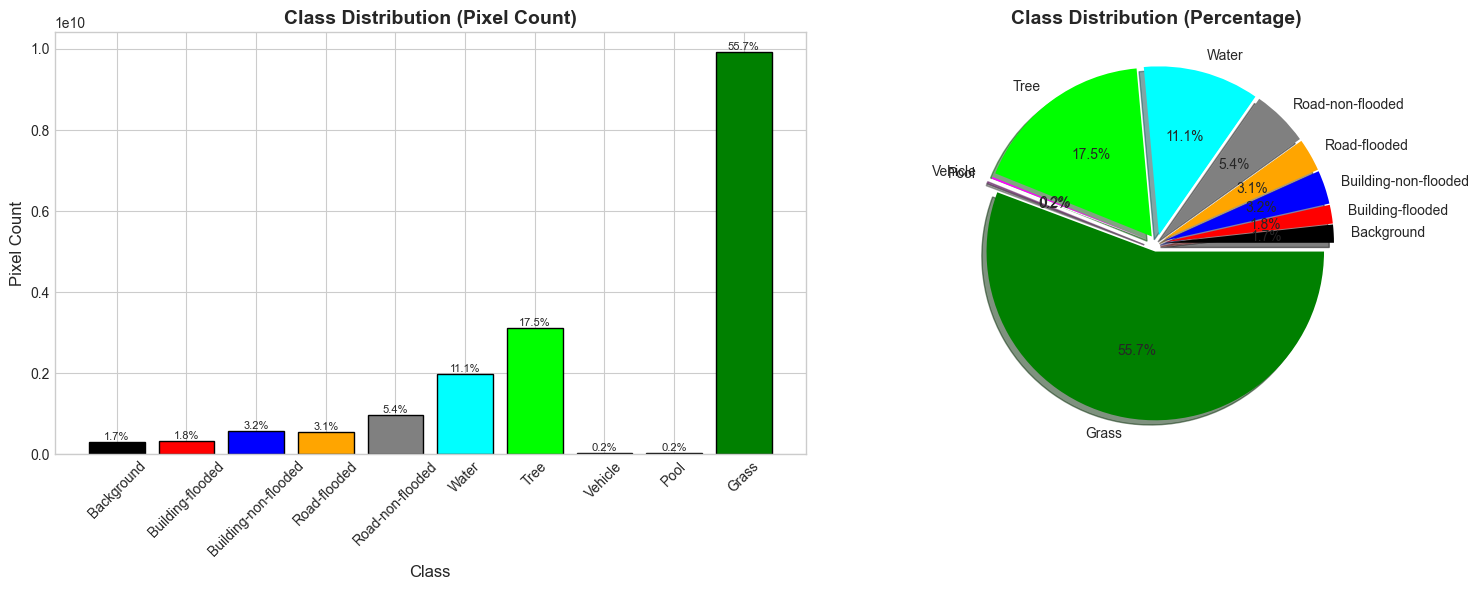

In [ ]:
# ============================================================
# 7. Visualize Class Distribution
# ------------------------------------------------------------
# Generate bar and pie charts summarizing pixel distribution
# across all segmentation classes.
# ============================================================

def plot_class_distribution(df, save_path=None):
    """Plot bar chart and pie chart for class distribution."""
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Bar chart colors mapped from class color metadata
    colors = [np.array(Config.CLASS_COLORS[i]) / 255 
              for i in range(Config.NUM_CLASSES)]

    # -------------------------
    # Bar Chart (Pixel Count)
    # -------------------------
    bars = axes[0].bar(
        df["Class Name"], 
        df["Pixel Count"], 
        color=colors,
        edgecolor='black'
    )

    axes[0].set_xlabel("Class", fontsize=12)
    axes[0].set_ylabel("Pixel Count", fontsize=12)
    axes[0].set_title("Class Distribution (Pixel Count)", fontsize=14, fontweight='bold')
    axes[0].tick_params(axis='x', rotation=45)

    # Add percentage labels above bars
    for bar, pct in zip(bars, df["Percentage"]):
        height = bar.get_height()
        axes[0].text(
            bar.get_x() + bar.get_width() / 2, 
            height,
            f"{pct:.1f}%", 
            ha="center", 
            va="bottom", 
            fontsize=8
        )

    # -------------------------
    # Pie Chart (Percentage)
    # -------------------------
    explode = [0.05] * Config.NUM_CLASSES  # small offset for each slice

    axes[1].pie(
        df["Percentage"], 
        labels=df["Class Name"],
        autopct="%1.1f%%",
        colors=colors,
        explode=explode,
        shadow=True
    )

    axes[1].set_title("Class Distribution (Percentage)", fontsize=14, fontweight='bold')

    plt.tight_layout()

    # Save figure if a path is provided
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
        print(f"Saved to: {save_path}")

    plt.show()


# Run visualization
plot_class_distribution(
    df_distribution,
    save_path=Config.VIZ_DIR / "class_distribution.png"
)


In [ ]:
# ============================================================
# 8. Calculate Class Weights
# ------------------------------------------------------------
# Compute weighting factors to reduce class imbalance impact
# during training. Supports:
#   - balanced: inverse frequency
#   - effective: "effective number of samples" (CVPR 2019)
# ============================================================

def calculate_class_weights(class_pixels, total_pixels, method='balanced'):
    """
    Compute class weights given pixel distribution.
    
    Args:
        class_pixels (Counter): pixel count per class
        total_pixels (int): total pixel count across masks
        method (str): 'balanced' or 'effective'
    
    Returns:
        dict: normalized weight per class
    """
    weights = {}
    num_classes = Config.NUM_CLASSES

    # Balanced = inverse frequency
    if method == 'balanced':
        for cls in range(num_classes):
            count = class_pixels.get(cls, 1)
            weights[cls] = total_pixels / (num_classes * count)

    # Effective number of samples (CVPR 2019)
    elif method == 'effective':
        beta = 0.9999
        for cls in range(num_classes):
            count = class_pixels.get(cls, 1)
            effective_num = 1 - np.power(beta, count)
            weights[cls] = (1 - beta) / effective_num

    # Normalize to max=1
    max_weight = max(weights.values())
    weights = {cls: w / max_weight for cls, w in weights.items()}

    return weights


# -------------------------
# Calculate & Print Weights
# -------------------------
print("\n" + "=" * 60)
print("CLASS WEIGHTS (for handling imbalance)")
print("=" * 60)

balanced_weights = calculate_class_weights(class_pixels, total_pixels, 'balanced')
effective_weights = calculate_class_weights(class_pixels, total_pixels, 'effective')

print("\nBalanced Weights:")
for cls in range(Config.NUM_CLASSES):
    print(f"  Class {cls} ({Config.CLASSES[cls]}): {balanced_weights[cls]:.4f}")

print("\nEffective Number Weights (recommended for severe imbalance):")
for cls in range(Config.NUM_CLASSES):
    print(f"  Class {cls} ({Config.CLASSES[cls]}): {effective_weights[cls]:.4f}")


# -------------------------
# Save weights to JSON
# -------------------------
import json

metrics_dir = Config.RESULTS_DIR / "metrics"
metrics_dir.mkdir(parents=True, exist_ok=True)

weights_path = metrics_dir / "class_weights.json"
with open(weights_path, 'w') as f:
    json.dump(
        {"balanced": balanced_weights, "effective": effective_weights},
        f,
        indent=2
    )

print(f"\nSaved to: {weights_path}")



CLASS WEIGHTS (for handling imbalance)

Balanced Weights:
  Class 0 (Background): 0.1056
  Class 1 (Building-flooded): 0.1024
  Class 2 (Building-non-flooded): 0.0570
  Class 3 (Road-flooded): 0.0583
  Class 4 (Road-non-flooded): 0.0338
  Class 5 (Water): 0.0165
  Class 6 (Tree): 0.0105
  Class 7 (Vehicle): 1.0000
  Class 8 (Pool): 0.8818
  Class 9 (Grass): 0.0033

Effective Number Weights (recommended for severe imbalance):
  Class 0 (Background): 1.0000
  Class 1 (Building-flooded): 1.0000
  Class 2 (Building-non-flooded): 1.0000
  Class 3 (Road-flooded): 1.0000
  Class 4 (Road-non-flooded): 1.0000
  Class 5 (Water): 1.0000
  Class 6 (Tree): 1.0000
  Class 7 (Vehicle): 1.0000
  Class 8 (Pool): 1.0000
  Class 9 (Grass): 1.0000

Saved to: D:\Projects\Image Segmentation for Disaster Resilience\Disaster-segmentation\results\metrics\class_weights.json


Saved to: D:\Projects\Image Segmentation for Disaster Resilience\Disaster-segmentation\results\visualizations\data_exploration\class_legend.png


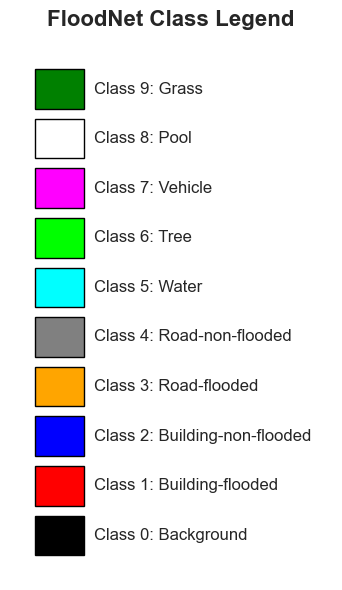

In [ ]:
# ============================================================
# 9. Create Class Legend
# ------------------------------------------------------------
# Generate a compact visual legend showing class IDs, names,
# and their corresponding mask colors.
# ============================================================

def create_class_legend(save_path=None):
    """Render a simple color legend for all segmentation classes."""
    
    fig, ax = plt.subplots(figsize=(10, 6))

    for i, (cls_id, cls_name) in enumerate(Config.CLASSES.items()):
        color = np.array(Config.CLASS_COLORS[cls_id]) / 255  # convert to [0,1]
        
        # Draw color block
        rect = plt.Rectangle((0, i), 1, 0.8, color=color, ec='black')
        ax.add_patch(rect)

        # Label text
        ax.text(
            1.2, i + 0.4, 
            f"Class {cls_id}: {cls_name}",
            va='center', fontsize=12
        )

    # Layout adjustments
    ax.set_xlim(-0.5, 6)
    ax.set_ylim(-0.5, Config.NUM_CLASSES + 0.5)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title("FloodNet Class Legend", fontsize=16, fontweight='bold')

    plt.tight_layout()

    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved to: {save_path}")

    plt.show()


# Generate & save the legend
create_class_legend(save_path=Config.VIZ_DIR / "class_legend.png")


In [ ]:
# ============================================================
# 10. Summary Statistics
# ------------------------------------------------------------
# Compact summary of dataset counts, image properties, class
# imbalance alerts, and generated output files.
# ============================================================

# Header

print("\n" + "=" * 60)
print("SUMMARY")
print("=" * 60)

# Summary block (concise, user-friendly)
print(f"""
Dataset Overview:
├── Training Set:   {stats['Train Images']['count']} images
├── Validation Set: {stats['Val Images']['count']} images
└── Test Set:       {stats['Test Images']['count']} images

Image Properties:
├── Original Size:  {dims[0] if dims else 'N/A'}
├── Target Size:    {Config.IMG_HEIGHT} x {Config.IMG_WIDTH}
└── Channels:       RGB (3)

Class Information:
├── Number of Classes: {Config.NUM_CLASSES}
├── Most Common:       {df_distribution.loc[df_distribution['Percentage'].idxmax(), 'Class Name']} ({df_distribution['Percentage'].max():.1f}%)
└── Least Common:      {df_distribution.loc[df_distribution['Percentage'].idxmin(), 'Class Name']} ({df_distribution['Percentage'].min():.2f}%)

   Class Imbalance Detected!
   → Use Focal Loss or weighted Cross-Entropy
   → Apply data augmentation
   → Monitor per-class IoU during training

Output Files:
├── {Config.VIZ_DIR / 'sample_train_images.png'}
├── {Config.VIZ_DIR / 'class_distribution.png'}
├── {Config.VIZ_DIR / 'class_legend.png'}
├── {Config.RESULTS_DIR / 'metrics' / 'class_distribution.csv'}
└── {Config.RESULTS_DIR / 'metrics' / 'class_weights.json'}
""")

# Footer
print("\n Data Exploration Complete! Ready for model training.")
print("Next Step: Run notebook 02_train_unet_basic.ipynb")


SUMMARY

Dataset Overview:
├── Training Set:   1445 images
├── Validation Set: 450 images
└── Test Set:       448 images

Image Properties:
├── Original Size:  (3000, 4000, 3)
├── Target Size:    256 x 256
└── Channels:       RGB (3)

Class Information:
├── Number of Classes: 10
├── Most Common:       Grass (55.7%)
└── Least Common:      Vehicle (0.18%)

   Class Imbalance Detected!
   → Use Focal Loss or weighted Cross-Entropy
   → Apply data augmentation
   → Monitor per-class IoU during training

Output Files:
├── D:\Projects\Image Segmentation for Disaster Resilience\Disaster-segmentation\results\visualizations\data_exploration\sample_train_images.png
├── D:\Projects\Image Segmentation for Disaster Resilience\Disaster-segmentation\results\visualizations\data_exploration\class_distribution.png
├── D:\Projects\Image Segmentation for Disaster Resilience\Disaster-segmentation\results\visualizations\data_exploration\class_legend.png
├── D:\Projects\Image Segmentation for Disaster Resil